In [14]:
import os
import cv2
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.metrics import IoU, Precision, Recall, Fscore

In [15]:
class RoadDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.tiff', '.tif'))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            mask = (mask > 0).float().unsqueeze(0)
        return image, mask

train_transform = A.Compose([
    A.RandomCrop(height=512, width=512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(p=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

val_transform = A.Compose([
    A.CenterCrop(height=512, width=512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

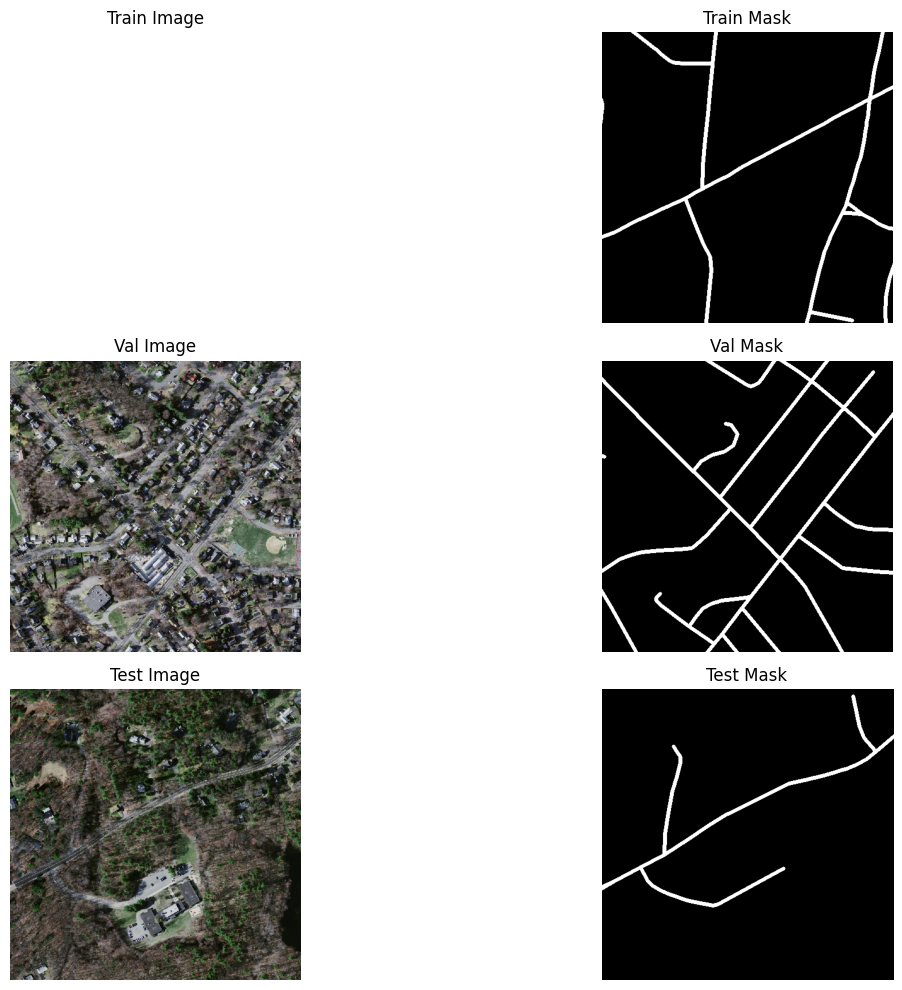

In [16]:
train_images = './MassachusettsRoads/train'
train_masks = './MassachusettsRoads/train_labels'
val_images = './MassachusettsRoads/val'
val_masks = './MassachusettsRoads/val_labels'
test_images = './MassachusettsRoads/test'
test_masks = './MassachusettsRoads/test_labels'

train_dataset = RoadDataset(train_images, train_masks, transform=train_transform)
val_dataset = RoadDataset(val_images, val_masks, transform=val_transform)
test_dataset = RoadDataset(test_images, test_masks, transform=val_transform)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def denormalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

train_img, train_mask = train_dataset[0]
val_img, val_mask = val_dataset[0]
test_img, test_mask = test_dataset[0]

train_img = denormalize(train_img).permute(1, 2, 0).numpy()
val_img = denormalize(val_img).permute(1, 2, 0).numpy()
test_img = denormalize(test_img).permute(1, 2, 0).numpy()
train_mask = train_mask.squeeze(0).numpy()
val_mask = val_mask.squeeze(0).numpy()
test_mask = test_mask.squeeze(0).numpy()

plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.imshow(train_img)
plt.title("Train Image")
plt.axis('off')
plt.subplot(3, 2, 2)
plt.imshow(train_mask, cmap='gray')
plt.title("Train Mask")
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(val_img)
plt.title("Val Image")
plt.axis('off')
plt.subplot(3, 2, 4)
plt.imshow(val_mask, cmap='gray')
plt.title("Val Mask")
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(test_img)
plt.title("Test Image")
plt.axis('off')
plt.subplot(3, 2, 6)
plt.imshow(test_mask, cmap='gray')
plt.title("Test Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", classes=1, activation=None)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

loss_fn = nn.BCEWithLogitsLoss()

iou = IoU(threshold=0.5)
precision = Precision(threshold=0.5)
recall = Recall(threshold=0.5)
fscore = Fscore(threshold=0.5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Device: mps


In [18]:
if os.path.exists("best_weights.pth"):
    model.load_state_dict(torch.load("best_weights.pth", map_location=device))
    print(f"Loaded weights from best_weights.pth")

num_epochs = 50
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_ious = []
val_precisions = []
val_recalls = []
val_fscores = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader, desc=f"Train {epoch+1}/{num_epochs}", colour="green"):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    val_iou = 0
    val_precision = 0
    val_recall = 0
    val_fscore = 0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Val {epoch+1}/{num_epochs}", colour="red"):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()
            val_iou += iou(outputs, masks).item()
            val_precision += precision(outputs, masks).item()
            val_recall += recall(outputs, masks).item()
            val_fscore += fscore(outputs, masks).item()
    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_precision /= len(val_loader)
    val_recall /= len(val_loader)
    val_fscore /= len(val_loader)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_fscores.append(val_fscore)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val Fscore: {val_fscore:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_weights.pth")
        print(f"Model saved with Val Loss: {val_loss:.4f}")

Val 1/50: 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


Epoch 1, Train Loss: 0.2431, Val Loss: 0.1341, Val IoU: 0.0000, Val Precision: 1.0000, Val Recall: 0.0000, Val Fscore: 0.0000
Model saved with Val Loss: 0.1341


Val 2/50: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 2, Train Loss: 0.1134, Val Loss: 0.1039, Val IoU: 0.4710, Val Precision: 0.7803, Val Recall: 0.5421, Val Fscore: 0.6395
Model saved with Val Loss: 0.1039


Val 3/50: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


Epoch 3, Train Loss: 0.1031, Val Loss: 0.1025, Val IoU: 0.4894, Val Precision: 0.7776, Val Recall: 0.5676, Val Fscore: 0.6562
Model saved with Val Loss: 0.1025


Val 4/50: 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Epoch 4, Train Loss: 0.1020, Val Loss: 0.0938, Val IoU: 0.3944, Val Precision: 0.8822, Val Recall: 0.4159, Val Fscore: 0.5649
Model saved with Val Loss: 0.0938


Val 5/50: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Epoch 5, Train Loss: 0.0995, Val Loss: 0.0971, Val IoU: 0.4209, Val Precision: 0.8861, Val Recall: 0.4443, Val Fscore: 0.5906


Val 6/50: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 6, Train Loss: 0.0971, Val Loss: 0.0859, Val IoU: 0.4908, Val Precision: 0.8599, Val Recall: 0.5330, Val Fscore: 0.6579
Model saved with Val Loss: 0.0859


Val 7/50: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 7, Train Loss: 0.0935, Val Loss: 0.0901, Val IoU: 0.5359, Val Precision: 0.8204, Val Recall: 0.6071, Val Fscore: 0.6975


Val 8/50: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


Epoch 8, Train Loss: 0.0946, Val Loss: 0.0850, Val IoU: 0.5514, Val Precision: 0.8286, Val Recall: 0.6216, Val Fscore: 0.7102
Model saved with Val Loss: 0.0850


Val 9/50: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Epoch 9, Train Loss: 0.0935, Val Loss: 0.0867, Val IoU: 0.5073, Val Precision: 0.8553, Val Recall: 0.5544, Val Fscore: 0.6724


Val 10/50: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Epoch 10, Train Loss: 0.0914, Val Loss: 0.0845, Val IoU: 0.5890, Val Precision: 0.7962, Val Recall: 0.6930, Val Fscore: 0.7410
Model saved with Val Loss: 0.0845


Val 11/50: 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 11, Train Loss: 0.0894, Val Loss: 0.0805, Val IoU: 0.5197, Val Precision: 0.8803, Val Recall: 0.5589, Val Fscore: 0.6835
Model saved with Val Loss: 0.0805


Val 12/50: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Epoch 12, Train Loss: 0.0901, Val Loss: 0.0809, Val IoU: 0.5525, Val Precision: 0.8392, Val Recall: 0.6174, Val Fscore: 0.7114


Val 13/50: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch 13, Train Loss: 0.0896, Val Loss: 0.0854, Val IoU: 0.5754, Val Precision: 0.8108, Val Recall: 0.6648, Val Fscore: 0.7304


Val 14/50: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 14, Train Loss: 0.0900, Val Loss: 0.0792, Val IoU: 0.5473, Val Precision: 0.8573, Val Recall: 0.6016, Val Fscore: 0.7069
Model saved with Val Loss: 0.0792


Val 15/50: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


Epoch 15, Train Loss: 0.0899, Val Loss: 0.0804, Val IoU: 0.5552, Val Precision: 0.8419, Val Recall: 0.6191, Val Fscore: 0.7134


Val 16/50: 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


Epoch 16, Train Loss: 0.0892, Val Loss: 0.0907, Val IoU: 0.5010, Val Precision: 0.8374, Val Recall: 0.5533, Val Fscore: 0.6659


Val 17/50: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Epoch 17, Train Loss: 0.0919, Val Loss: 0.0803, Val IoU: 0.5595, Val Precision: 0.8482, Val Recall: 0.6210, Val Fscore: 0.7167


Val 18/50: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch 18, Train Loss: 0.0889, Val Loss: 0.0803, Val IoU: 0.5490, Val Precision: 0.8688, Val Recall: 0.5984, Val Fscore: 0.7083


Val 19/50: 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]


Epoch 19, Train Loss: 0.0872, Val Loss: 0.0771, Val IoU: 0.5638, Val Precision: 0.8501, Val Recall: 0.6259, Val Fscore: 0.7209
Model saved with Val Loss: 0.0771


Val 20/50: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch 20, Train Loss: 0.0883, Val Loss: 0.0826, Val IoU: 0.5327, Val Precision: 0.8593, Val Recall: 0.5824, Val Fscore: 0.6939


Val 21/50: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 21, Train Loss: 0.0922, Val Loss: 0.0804, Val IoU: 0.5467, Val Precision: 0.8503, Val Recall: 0.6041, Val Fscore: 0.7062


Val 22/50: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 22, Train Loss: 0.0894, Val Loss: 0.0787, Val IoU: 0.5463, Val Precision: 0.8629, Val Recall: 0.5976, Val Fscore: 0.7061


Val 23/50: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 23, Train Loss: 0.0884, Val Loss: 0.0779, Val IoU: 0.5632, Val Precision: 0.8624, Val Recall: 0.6183, Val Fscore: 0.7200


Val 24/50: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch 24, Train Loss: 0.0872, Val Loss: 0.0865, Val IoU: 0.4361, Val Precision: 0.9042, Val Recall: 0.4568, Val Fscore: 0.6064


Val 25/50: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch 25, Train Loss: 0.0894, Val Loss: 0.0767, Val IoU: 0.5644, Val Precision: 0.8760, Val Recall: 0.6132, Val Fscore: 0.7209
Model saved with Val Loss: 0.0767


Val 26/50: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch 26, Train Loss: 0.0848, Val Loss: 0.0756, Val IoU: 0.5568, Val Precision: 0.8740, Val Recall: 0.6051, Val Fscore: 0.7149
Model saved with Val Loss: 0.0756


Val 27/50: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch 27, Train Loss: 0.0838, Val Loss: 0.0769, Val IoU: 0.5764, Val Precision: 0.8441, Val Recall: 0.6442, Val Fscore: 0.7306


Val 28/50: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch 28, Train Loss: 0.0847, Val Loss: 0.0778, Val IoU: 0.5653, Val Precision: 0.8474, Val Recall: 0.6287, Val Fscore: 0.7215


Val 29/50: 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 29, Train Loss: 0.0829, Val Loss: 0.0745, Val IoU: 0.5748, Val Precision: 0.8594, Val Recall: 0.6341, Val Fscore: 0.7295
Model saved with Val Loss: 0.0745


Val 30/50: 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch 30, Train Loss: 0.0843, Val Loss: 0.0820, Val IoU: 0.5321, Val Precision: 0.8728, Val Recall: 0.5760, Val Fscore: 0.6930


Val 31/50: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 31, Train Loss: 0.0847, Val Loss: 0.0748, Val IoU: 0.5620, Val Precision: 0.8908, Val Recall: 0.6033, Val Fscore: 0.7190


Val 32/50: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 32, Train Loss: 0.0826, Val Loss: 0.0799, Val IoU: 0.5581, Val Precision: 0.8513, Val Recall: 0.6186, Val Fscore: 0.7154


Val 33/50: 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Epoch 33, Train Loss: 0.0846, Val Loss: 0.0973, Val IoU: 0.4470, Val Precision: 0.8783, Val Recall: 0.4761, Val Fscore: 0.6174


Val 34/50: 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


Epoch 34, Train Loss: 0.0919, Val Loss: 0.0852, Val IoU: 0.5714, Val Precision: 0.8133, Val Recall: 0.6564, Val Fscore: 0.7261


Val 35/50: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch 35, Train Loss: 0.0888, Val Loss: 0.0788, Val IoU: 0.5691, Val Precision: 0.8633, Val Recall: 0.6253, Val Fscore: 0.7252


Val 36/50: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch 36, Train Loss: 0.0866, Val Loss: 0.0754, Val IoU: 0.5708, Val Precision: 0.8736, Val Recall: 0.6214, Val Fscore: 0.7258


Val 37/50: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch 37, Train Loss: 0.0860, Val Loss: 0.0787, Val IoU: 0.5822, Val Precision: 0.8436, Val Recall: 0.6519, Val Fscore: 0.7350


Val 38/50: 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


Epoch 38, Train Loss: 0.0866, Val Loss: 0.0804, Val IoU: 0.5687, Val Precision: 0.8400, Val Recall: 0.6372, Val Fscore: 0.7245


Val 39/50: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 39, Train Loss: 0.0838, Val Loss: 0.0779, Val IoU: 0.6160, Val Precision: 0.8165, Val Recall: 0.7145, Val Fscore: 0.7620


Val 40/50: 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 40, Train Loss: 0.0829, Val Loss: 0.0747, Val IoU: 0.5902, Val Precision: 0.8578, Val Recall: 0.6535, Val Fscore: 0.7416


Val 41/50: 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


Epoch 41, Train Loss: 0.0828, Val Loss: 0.0761, Val IoU: 0.5661, Val Precision: 0.8798, Val Recall: 0.6125, Val Fscore: 0.7221


Val 42/50: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch 42, Train Loss: 0.0840, Val Loss: 0.0755, Val IoU: 0.5837, Val Precision: 0.8736, Val Recall: 0.6365, Val Fscore: 0.7362


Val 43/50: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 43, Train Loss: 0.0872, Val Loss: 0.0771, Val IoU: 0.5581, Val Precision: 0.8656, Val Recall: 0.6103, Val Fscore: 0.7158


Val 44/50: 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 44, Train Loss: 0.0868, Val Loss: 0.0765, Val IoU: 0.5720, Val Precision: 0.8635, Val Recall: 0.6282, Val Fscore: 0.7273


Val 45/50: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch 45, Train Loss: 0.0833, Val Loss: 0.0775, Val IoU: 0.5692, Val Precision: 0.8627, Val Recall: 0.6259, Val Fscore: 0.7251


Val 46/50: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 46, Train Loss: 0.0842, Val Loss: 0.0761, Val IoU: 0.5520, Val Precision: 0.8752, Val Recall: 0.5987, Val Fscore: 0.7102


Val 47/50: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 47, Train Loss: 0.0821, Val Loss: 0.0763, Val IoU: 0.5896, Val Precision: 0.8475, Val Recall: 0.6591, Val Fscore: 0.7415


Val 48/50: 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 48, Train Loss: 0.0813, Val Loss: 0.0762, Val IoU: 0.5880, Val Precision: 0.8603, Val Recall: 0.6497, Val Fscore: 0.7402


Val 49/50: 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]


Epoch 49, Train Loss: 0.0839, Val Loss: 0.0816, Val IoU: 0.5496, Val Precision: 0.8725, Val Recall: 0.5970, Val Fscore: 0.7086


Val 50/50: 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Epoch 50, Train Loss: 0.0839, Val Loss: 0.0787, Val IoU: 0.5292, Val Precision: 0.8885, Val Recall: 0.5660, Val Fscore: 0.6905


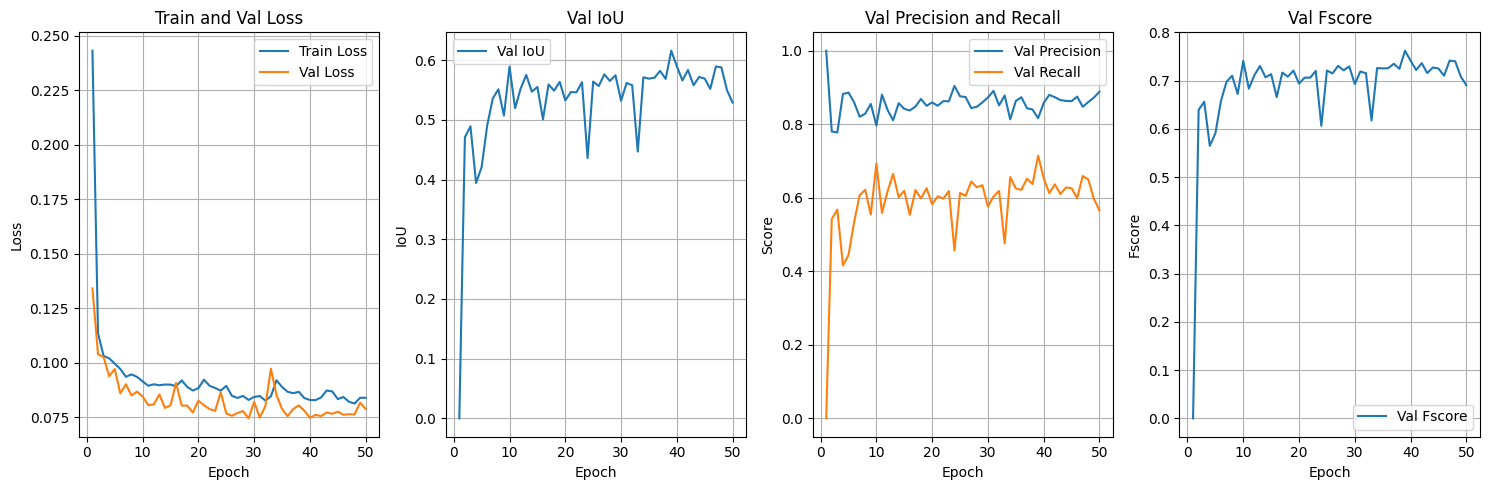

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Val Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 4, 2)
plt.plot(range(1, len(val_ious) + 1), val_ious, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Val IoU')
plt.legend()
plt.grid(True)

plt.subplot(1, 4, 3)
plt.plot(range(1, len(val_precisions) + 1), val_precisions, label='Val Precision')
plt.plot(range(1, len(val_recalls) + 1), val_recalls, label='Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Val Precision and Recall')
plt.legend()
plt.grid(True)

plt.subplot(1, 4, 4)
plt.plot(range(1, len(val_fscores) + 1), val_fscores, label='Val Fscore')
plt.xlabel('Epoch')
plt.ylabel('Fscore')
plt.title('Val Fscore')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
model.load_state_dict(torch.load("best_weights.pth", map_location=device))
print(f"Loaded weights from best_weights.pth")

model.eval()
test_iou = 0
test_precision = 0
test_recall = 0
test_fscore = 0
test_predictions = []

with torch.no_grad():
    for i, (images, masks) in enumerate(tqdm(test_loader, desc="Testing", colour="blue")):
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        test_iou += iou(outputs, masks).item()
        test_precision += precision(outputs, masks).item()
        test_recall += recall(outputs, masks).item()
        test_fscore += fscore(outputs, masks).item()

        if len(test_predictions) < 3:
            preds = torch.sigmoid(outputs) > 0.5
            preds_np = preds.cpu().numpy().astype(np.uint8)
            for j in range(min(images.size(0), 3 - len(test_predictions))):
                pred = preds_np[j].squeeze(0)
                test_predictions.append((images[j].cpu(), masks[j].cpu(), torch.tensor(pred, dtype=torch.float32)))

test_iou /= len(test_loader)
test_precision /= len(test_loader)
test_recall /= len(test_loader)
test_fscore /= len(test_loader)
print(f"Test IoU: {test_iou:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test Fscore: {test_fscore:.4f}")

Loaded weights from best_weights.pth


Testing: 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

Test IoU: 0.4948, Test Precision: 0.8801, Test Recall: 0.5420, Test Fscore: 0.6348


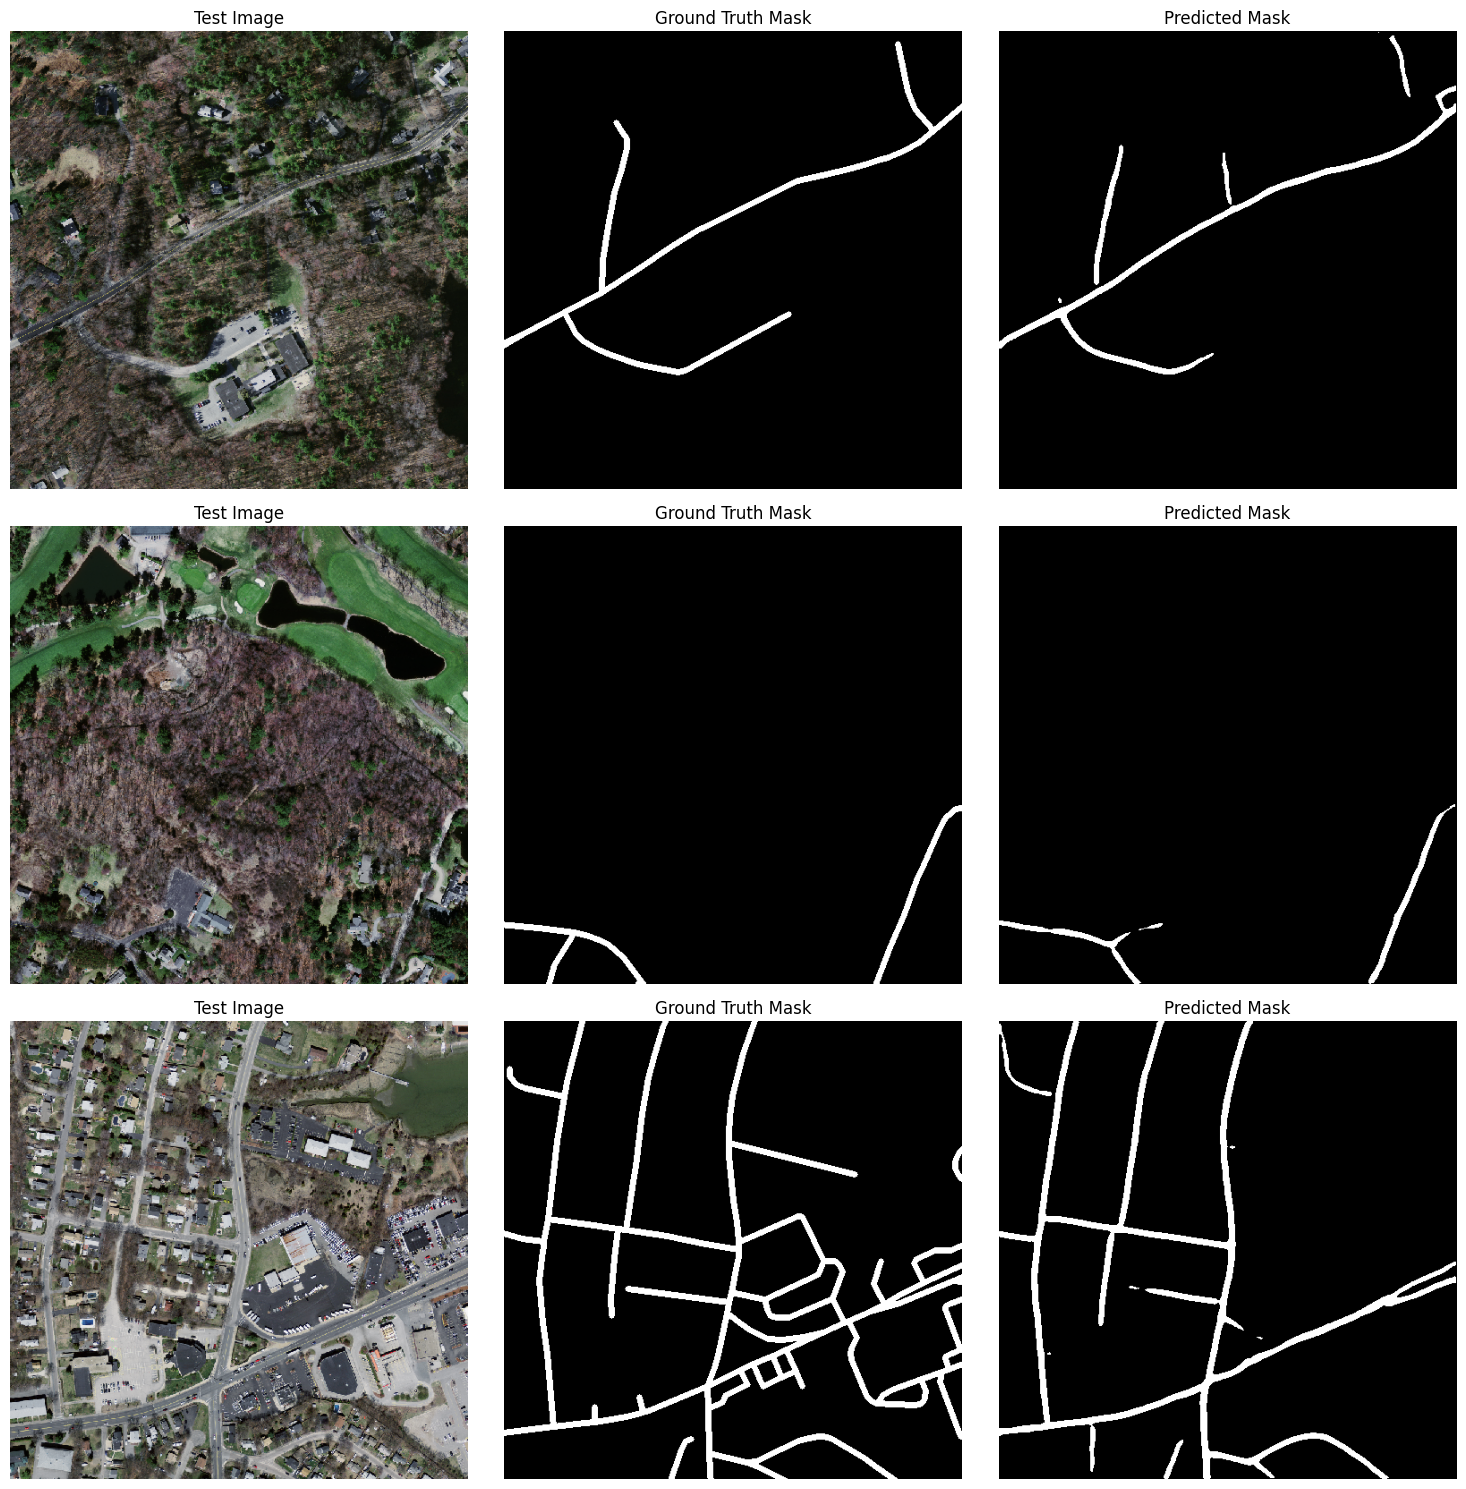

In [21]:
plt.figure(figsize=(15, 5 * 3))
for i, (img, mask, pred) in enumerate(test_predictions):
    img = denormalize(img).permute(1, 2, 0).numpy()
    mask = mask.squeeze(0).numpy()
    pred = pred.numpy()

    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(img)
    plt.title("Test Image")
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(pred, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()